## Проверка эластичности банковских показателей с посещениями на сайте banki.ru

период март - апрель 2021

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
import matplotlib.pyplot as plt
from scipy.stats import shapiro, variation
import seaborn as sns

%matplotlib inline

In [2]:
plt.style.use('seaborn') 
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
os.chdir(r'\\tsclient\X\УМиР\Аманов\Adhoc\bankiru_visitors')

In [4]:
filials_manual = pd.read_excel('Справочник_филиалы.xlsx')
bankiru = pd.read_excel('bankiru_visitors_март_апрель.xlsx')
talons = pd.read_excel('Количество взятых талонов март, апрель 2021.xlsx')
bank_revenue = pd.read_excel('Ежедневный_отчет_по_Банку_март_апрель.xlsx', sheet_name='Доход')
bank_quantity = pd.read_excel('Ежедневный_отчет_по_Банку_март_апрель.xlsx', sheet_name='Кол-во')

### Загружу информацию по посещениям из отчета banki.ru, кол-ву выданных талонов, доход и кол-во операций по отделениям

In [5]:
bankiru.head()

Банкиру  02.03  03.03  04.03  \
0          Заубер Банк - Комендантский пр-т, д. 16к1     32     16     18   
1      Заубер Банк - м. Звездная, ул.Звездная, д.5к1     19     22     17   
2  Заубер Банк - м. Лиговский пр-т, ул.Марата, д....     27     43     21   
3    Заубер Банк - м. Международная, ул. Б.Куна, д.8     31     25     22   
4    Заубер Банк - м. Наличная, ул.Наличная, д. 40к1     37     19     14   

   05.03  06.03  07.03  08.03  09.03  10.03  ...  29.03  30.03  31.03  01.04  \
0     14      8      9      9     13     13  ...     34     26     32     25   
1     16     21     18     15     17     21  ...     43     28     39     29   
2     26     46     42     41     61     58  ...     42     41     47     36   
3     30     20     22     19     33     43  ...     48     62     36     47   
4     21     11     12     14     25     19  ...     20     15     19     19   

   02.04  03.04  04.04  05.04  06.04  07.04  
0     22     14     17     15     34     33  
1     18     15     13     19     42     47  
2     34     25     13     43     71     99  
3     27     16     14     35     50     37  
4     12      9      4     15     36     38  

[5 rows x 38 columns]

In [6]:
talons.head()

Леши номерки  2021-03-02 00:00:00  2021-03-03 00:00:00  \
0  Головное отделение                  163                  133   
1              ДО №1                   100                   75   
2  ДО №2 "Московский"                   53                   63   
3    ДО №3 "Жулебино"                  134                  113   
4      ДО №4 "Пресня"                   99                   89   

   2021-03-04 00:00:00  2021-03-05 00:00:00  2021-03-06 00:00:00  \
0                  149                  151                   72   
1                   96                   82                   72   
2                   71                   56                   37   
3                  134                  132                  119   
4                   79                   87                   37   

   2021-03-07 00:00:00  2021-03-08 00:00:00  2021-03-09 00:00:00  \
0                   64                   39                  143   
1                   58                   29                   91   
2                   19                   18                   74   
3                   70                   61                  126   
4                   31                   17                   98   

   2021-03-10 00:00:00  ...  2021-03-29 00:00:00  2021-03-30 00:00:00  \
0                  124  ...                  180                  161   
1                   97  ...                   86                  101   
2                   57  ...                   72                   69   
3                  152  ...                  166                  155   
4                   82  ...                  105                  106   

   2021-03-31 00:00:00  2021-04-01 00:00:00  2021-04-02 00:00:00  \
0                  130                  177                133.0   
1                   92                   89                 97.0   
2                   72                   75                  NaN   
3                  151                  151                115.0   
4                  105                   82                 99.0   

   2021-04-03 00:00:00  2021-04-04 00:00:00  2021-04-05 00:00:00  \
0                  109                   77                  177   
1                   59                   56                   82   
2                   38                   36                   64   
3                  104                   86                  160   
4                   47                   37                   99   

   2021-04-06 00:00:00  2021-04-07 00:00:00  
0                  160                  143  
1                  101                   99  
2                   84                  103  
3                  130                  155  
4                   63                  100  

[5 rows x 38 columns]

In [7]:
rng = pd.date_range(start='2021-03-02', end='2021-04-07')

### произведем предобработку данных

In [8]:
bankiru = bankiru.merge(filials_manual, copy=False)
bankiru = bankiru.rename(columns={'Ежедневный отчет': 'Отделение'})
for column in ['Ежедневный отчет', 'Леши номерки', 'Банкиру']:
    try:
        bankiru.drop(column, axis=1, inplace=True)
    except:
        continue
bankiru = bankiru.set_index('Отделение')
bankiru.columns = rng
        
talons = talons.merge(filials_manual, copy=False)
talons = talons.rename(columns={'Ежедневный отчет': 'Отделение'})
for column in ['Ежедневный отчет', 'Леши номерки', 'Банкиру']:
    try:
        talons.drop(column, axis=1, inplace=True)
    except:
        continue
talons = talons.set_index('Отделение')    
talons.columns = rng
        
bank_revenue = bank_revenue.merge(filials_manual, copy=False)
bank_revenue = bank_revenue.rename(columns={'Ежедневный отчет': 'Отделение'})
for column in ['Ежедневный отчет', 'Леши номерки', 'Банкиру']:
    try:
        bank_revenue.drop(column, axis=1, inplace=True)
    except:
        continue
bank_revenue = bank_revenue.set_index('Отделение')    
bank_revenue.columns = rng
        
bank_quantity = bank_quantity.merge(filials_manual, copy=False)
bank_quantity = bank_quantity.rename(columns={'Ежедневный отчет': 'Отделение'})
for column in ['Ежедневный отчет', 'Леши номерки', 'Банкиру']:
    try:
        bank_quantity.drop(column, axis=1, inplace=True)
    except:
        continue 
bank_quantity = bank_quantity.set_index('Отделение')    
bank_quantity.columns = rng

In [9]:
bases = dict(zip(('БанкиРу', 'Талоны', 'Доход', 'Кол-во операций'), (bankiru, talons, bank_revenue, bank_quantity)))
normality = {'Отделение': []}
for base in bases:
    test_name = f'Тест Шапиро-Вилка - {base}'
    normality.setdefault(test_name, [])
    for index in bases[base].index:
        normality['Отделение'].append(index)
        stat, p = shapiro(bases[base].loc[index, :])
        normality[test_name].append(p)

In [10]:
normality_frame = pd.DataFrame({key: val[:31] if key == 'Отделение' else val for key, val in normality.items()})

### Тестом Шапиро-Вилка проверим получившиеся распределения на нормальность

In [11]:
normality_frame.to_excel('Шапиро.xlsx')

### Визуально проверю достоверность теста

<AxesSubplot:>

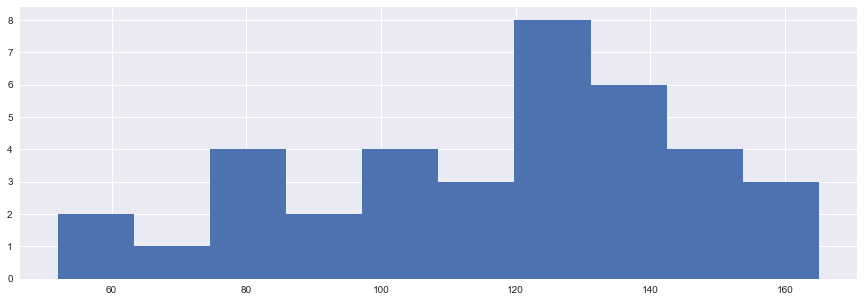

In [12]:
bank_quantity.loc['Теплый стан-ОКВКУ 17',:].hist()

<AxesSubplot:>

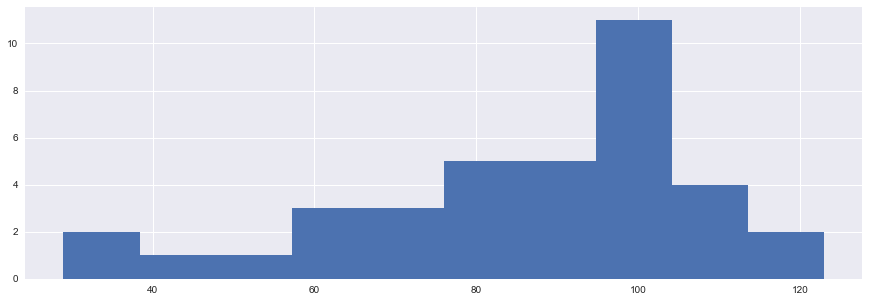

In [13]:
talons.loc['Марата-ДО 1',:].hist()

### Тесту можно верить, большая часть распределений - нормальна

In [14]:
pd.Series(np.array(normality_frame[[column for column in normality_frame.columns if column != 'Отделение']] > 0.05).flatten()).value_counts()

True     68
False    56
dtype: int64

In [15]:
tests = normality_frame[[column for column in normality_frame.columns if column != 'Отделение']] > 0.05

In [16]:
for column in tests.columns:
    print(tests[column].value_counts())

True     16
False    15
Name: Тест Шапиро-Вилка - БанкиРу, dtype: int64
True     19
False    12
Name: Тест Шапиро-Вилка - Талоны, dtype: int64
True     19
False    12
Name: Тест Шапиро-Вилка - Доход, dtype: int64
False    17
True     14
Name: Тест Шапиро-Вилка - Кол-во операций, dtype: int64


### Проверил кол-во нормальных и ненормальных распределений по данным, кол-во нормальных и ненормальных распределений примерно одинаково

Text(0.5, 1.0, 'Банки.ру кол-во посещений')

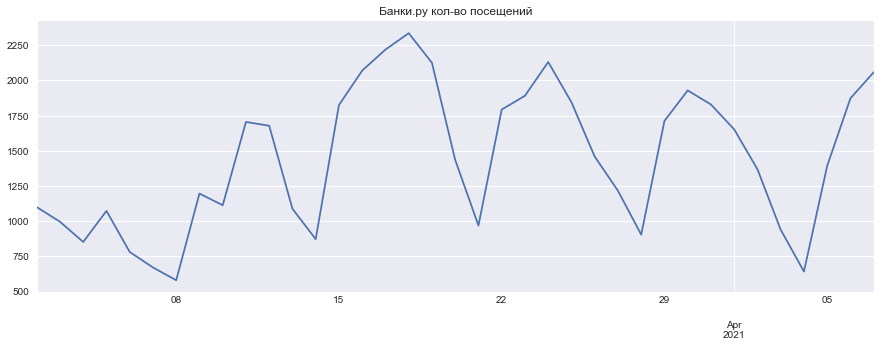

In [17]:
bankiru.sum(axis=0).plot()

plt.title('Банки.ру кол-во посещений')

### На графике видно что кол-во посещений в будни на сайте banki.ru выросло по сравнению с началом марта

Text(0.5, 1.0, 'Выдано талонов, суммарно')

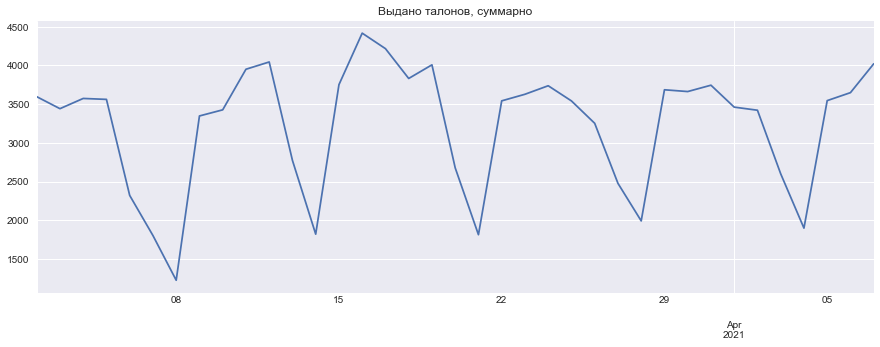

In [18]:
talons.sum(axis=0).plot()
plt.title('Выдано талонов, суммарно')

Text(0.5, 1.0, 'Доход')

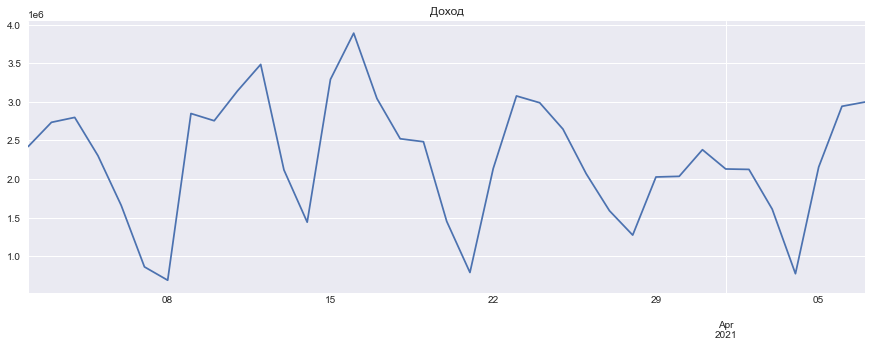

In [19]:
bank_revenue.sum(axis=0).plot()
plt.title('Доход')

Text(0.5, 1.0, 'Кол-во операций')

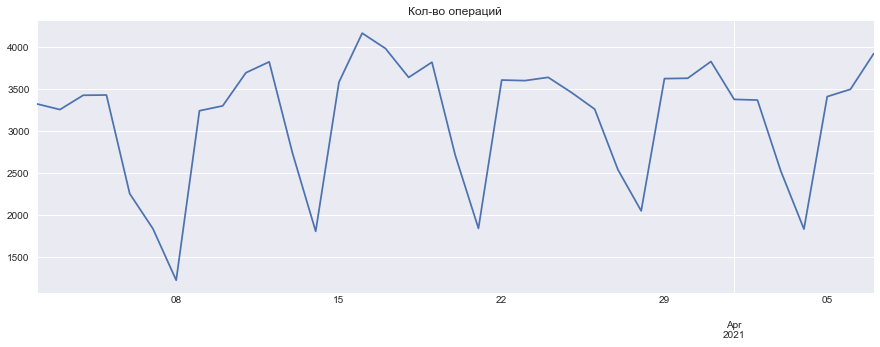

In [20]:
bank_quantity.sum(axis=0).plot()
plt.title('Кол-во операций')

### схожие графики по всем показателям

In [21]:
for_correl = pd.DataFrame([pd.Series(bank_quantity.sum(axis=0), name='Кол-во операций'), pd.Series(bank_revenue.sum(axis=0), name='Доход'), pd.Series(talons.sum(axis=0), name='Кол-во выданных талонов'), pd.Series(bankiru.sum(axis=0), name='Банки.ру')]).T

In [14]:
sns.heatmap(for_correl.corr())

NameError: name 'for_correl' is not defined

### Согласно тепловой карте корреляций наименьшая связь между доходом банка и кол-вом посещений на сайте banki.ru. Тем не менее связь существена, более 0.7. Между остальными показателями связь сильнее, от 0.8 и выше

In [15]:
variation_df = {'Отделение': [], 'Коэффициент вариации, %': []}

for index in bankiru.index:
    variation_df['Отделение'].append(index)
    variation_df['Коэффициент вариации, %'].append(f'{variation(bankiru.loc[index, :]) * 100:.2f}%')
    
variation_df = pd.DataFrame(variation_df)

variation_df = variation_df.sort_values(by='Коэффициент вариации, %', ascending=False)


In [16]:
variation_df.to_excel('Вариация.xlsx')

### проверил вариативность кол-ва посещений, видно что она существенно отличается у части отделений

In [17]:
otdels = variation_df['Отделение'].to_list()


In [18]:
correlation_table = {'Отделение': [], 'Кол-во операций':[], 'Доход':[], 'Кол-во выданных талонов': []}
for otdel in otdels:
    temp_correl = pd.DataFrame([pd.Series(bank_quantity.loc[otdel, :], name='Кол-во операций'), pd.Series(bank_revenue.loc[otdel, :], name='Доход'), pd.Series(talons.loc[otdel, :], name='Кол-во выданных талонов'), pd.Series(bankiru.loc[otdel, :], name='Банки.ру')]).T
    temp_correl = temp_correl.corr()['Банки.ру']
    for key in correlation_table.keys():  
        if key == 'Отделение':
            correlation_table[key].append(otdel)
        else:    
            correlation_table[key].append(round(temp_correl[key], 2))

correlation_table = pd.DataFrame(correlation_table).sort_values(by=['Доход', 'Кол-во операций', 'Кол-во выданных талонов'], ascending=False)[['Отделение', 'Доход', 'Кол-во операций', 'Кол-во выданных талонов']].reset_index(drop=True)

In [19]:
correlation_table.to_excel('таблицакорр.xlsx')

### сделал таблицу корреляций по отделениям между показателями дохода, кол-ва операций, кол-ва выданных талонов и посещениями на сайте banki.ru, видно что часть отделений лучше реагирует на изменение кол-ва посещений на сайте